<a href="https://colab.research.google.com/github/YuxingW/machine_learning/blob/main/hw8/micro_factors_sentiment_confirmation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW8 Microfactors of pychology utilities

* Reference: 
* https://towardsai.net/p/nlp/sentiment-analysis-opinion-mining-with-python-nlp-tutorial-d1f173ca4e3c

* https://github.com/towardsai/tutorials/tree/master/sentiment_analysis_tutorial

## Data preparation

**Scrape data from politifact**

In [1]:
!pip install beautifulsoup4
!pip install vaderSentiment

In [2]:
import requests 
import pandas as pd 
from bs4 import BeautifulSoup  

In [3]:
#Get all issues

url = "https://www.politifact.com/issues/"
issues = []
r = requests.get(url)
soup = BeautifulSoup(r.text,'html.parser')
results = soup.find_all('div', attrs={'class':'c-chyron__value'})
for result in results:
  name = result.find('a').text
  issue = result.find('a')['href'].replace("/","")
  issues.append((name, issue))

In [4]:
url = "https://www.politifact.com/factchecks/list/?page={pgno}&category={category}"

records = []  

for i in range(1,2):
  for issue, issue_url in issues[:5]:
    fUrl = url.format(pgno=str(i), category=issue_url)
    r = requests.get(fUrl)
    soup = BeautifulSoup(r.text, 'html.parser')  
    results = soup.find_all('article', attrs={'class':'m-statement'})
    for result in results:
      date = result.find('footer',attrs={'class':'m-statement__footer'}).text.split("•")[1].rstrip("\n")
      reporter = result.find('footer',attrs={'class':'m-statement__footer'}).text.split("•")[0].replace("\nBy","")   
      author = result.find('a',attrs={'class':'m-statement__name'}).text.replace("\n","")
      statement =  result.find('div', attrs = {'class':'m-statement__quote'}).find('a').text.replace("\n","")
      statement_descr = result.find('div', {'class':'m-statement__desc'}).text.replace("\n","")
      article_url =  result.find('a')['href']
      verdict = result.find('img', attrs = {'class':'c-image__thumb'}, alt=True).attrs['alt']
      records.append(( date, issue, reporter, author, statement, statement_descr, verdict, article_url))
  
df_sample = pd.DataFrame(records, columns=['Date', 'Issue','Reporter','Author', 'Statement', 'Description', 'Verdict', 'Url'])  
df_sample.head()

,Date,Issue,Reporter,Author,Statement,Description,Verdict,Url
0,"March 31, 2021",Abortion,Tom Kertscher,Facebook posts,“Joe Biden puts pro-life groups on domestic ex...,"stated on March 29, 2021 in a Facebook post:",barely-true,/personalities/facebook-posts/
1,"February 12, 2021",Abortion,Brandon Mulder,Greg Abbott,“Innocent lives will be saved” by ending taxpa...,"stated on January 24, 2021 in a tweet:",false,/personalities/greg-abbott/
2,"November 18, 2020",Abortion,Noah Y. Kim,Facebook posts,There is “aborted male fetus” in the Oxford-As...,"stated on November 15, 2020 in a Facebook post:",false,/personalities/facebook-posts/
3,"October 14, 2020",Abortion,Tom Kertscher,Tommy Tuberville,"Says Doug Jones ""has voted to spend our tax do...","stated on October 8, 2020 in an ad:",false,/personalities/tommy-tuberville/
4,"October 13, 2020",Abortion,Chris Nichols,Facebook posts,“Kamala Harris Tried to Put Pro-Lifers in Jail...,"stated on August 14, 2020 in a headline:",false,/personalities/facebook-posts/


In [5]:
df_sample.isnull().sum()

Date           0
Issue          0
Reporter       0
Author         0
Statement      0
Description    0
Verdict        0
Url            0
dtype: int64

**Import Required Packages**

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import requests
import string
from string import punctuation
from io import BytesIO
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Get twitter dataset**

In [7]:
train_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-7fkaGbvXcppizTYkyM_weWptbtyab7PVUXJZdpJb7aJ-mKXtB1zTkY7DizLU7M64oYMoE8lPJQ1V/pub?output=csv'
r = requests.get(train_url)
data = r.content
df_train = pd.read_csv(BytesIO(data))
df_train.head()

,Statement,VerdictRating,NumOfRetweets
0,BREAKING: Nancy Pelosi Was Just Taken From Her...,Negative,378
1,Student Hasn't Stopped Filming Since Florida S...,Negative,43
2,Court Orders Obama To Pay $400 Million In Rest...,Negative,102
3,Florida Democrats Ask HHS to Protect Floridian...,Positive,216
4,the Border Security Economic Opportunity and I...,Positive,66


**Plot the Rating visualization graph**

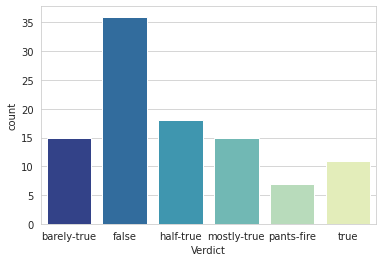

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='Verdict',data=df_sample, palette='YlGnBu_r')

**Calculation of Polarity**

In [9]:
df_sample['VerdictRating'] = df_sample['Verdict'].apply(lambda x: 'Positive' if x in ['true', 'mostly-true', 'half-true'] else 'Negative')


## Microfactors generation

**1. Confirmation generation**

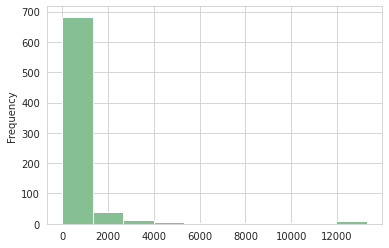

In [10]:
pd.options.mode.chained_assignment = None

ulimit = np.percentile(df_train.NumOfRetweets, 99)
df_train['NumOfRetweets'].loc[df_train['NumOfRetweets']>ulimit] = ulimit
llimit = np.percentile(df_train.NumOfRetweets.values, 1)
df_train['NumOfRetweets'].loc[df_train['NumOfRetweets']<llimit] = llimit
df_train['NumOfRetweets'].plot.hist(color='#86bf91')

Where we can see very few of them have over than 2000 retweets.

The more retweets, the more social confirmation. We split the number of retwees to 'Confirmation' as 'positive' and 'negative', 300 is the threshold we can use for social media.

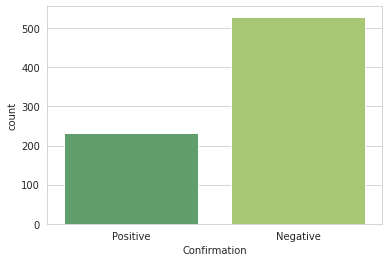

In [11]:
df_train['Confirmation'] = df_train['NumOfRetweets'].apply(lambda x: 'Positive' if x > 300 else 'Negative')
sns.set_style('whitegrid')
sns.countplot(x='Confirmation',data=df_train, palette='summer')

**Text Preprocessing**

In [12]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

**Apply the method "get_text_processing" into column statement text**

In [13]:
df_train['Statement'] = df_train['Statement'].apply(get_text_processing)
df_sample['Statement'] = df_sample['Statement'].apply(get_text_processing)


**2. Sentiment Generation**

In [14]:
def get_text_sentiment(text):
  analyzer = SentimentIntensityAnalyzer()
  _sentiment = analyzer.polarity_scores(text)["compound"]
  return 'Positive' if abs(_sentiment) > 0.5 else 'Negative'

**Apply the method "get_text_setiment" into column statement text**

In [15]:
df_train['Sentiment'] = df_train['Statement'].apply(get_text_sentiment)
df_sample['Sentiment'] = df_sample['Statement'].apply(get_text_sentiment)

**Visualize Sentiment Polarity**

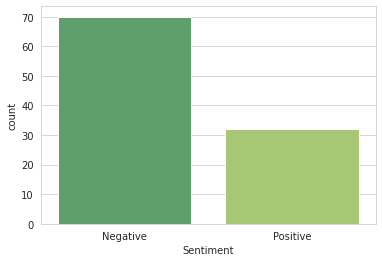

In [16]:
sns.set_style('whitegrid')
sns.countplot(x='Sentiment',data=df_sample, palette='summer')

In [17]:
df = pd.concat([df_train,df_sample[['Statement', 'Sentiment', 'VerdictRating']]],axis=0)
df = df.sample(frac=1).reset_index(drop=True)
df = df.fillna(df.mean())
df['Confirmation'] = df['NumOfRetweets'].apply(lambda x: 'Positive' if x > 300 else 'Negative')
df.head()

,Statement,VerdictRating,NumOfRetweets,Confirmation,Sentiment
0,Starbucks Placed Trump’s Photo Floor Every Cus...,Negative,106.000000,Negative,Negative
1,Justices 1789 Present,Positive,244.000000,Negative,Negative
2,Leonard Lance claims federal tax code contains...,Positive,4.000000,Negative,Negative
3,AARP backed federal funding Planned Parenthood,Negative,665.357375,Positive,Negative
4,Obama’s PrimeTime Press Briefing,Positive,3.000000,Negative,Negative


In [18]:
df.isnull().sum()

Statement        0
VerdictRating    0
NumOfRetweets    0
Confirmation     0
Sentiment        0
dtype: int64

## Apply muller loop classifiers on first micro-factor: Sentiment

**Apply Train Test Split**

In [19]:
X, y = df['Statement'].values, df['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

**Apply vectorization**

In [20]:
def apply_count_vector(X_train, X_test):
  vect = CountVectorizer()
  X_train = vect.fit_transform(X_train)
  X_test = vect.transform(X_test)
  return X_train, X_test

**Apply frequency, inverse document frequency:**

In [21]:
def apply_tfidf(X_train, X_test):
  tfidf = TfidfTransformer()
  X_train = tfidf.fit_transform(X_train)
  X_test = tfidf.transform(X_test)
  X_train = X_train.toarray()
  X_test = X_test.toarray()
  return X_train, X_test

In [22]:
X_train, X_test = apply_count_vector(X_train, X_test)
X_train, X_test = apply_tfidf(X_train, X_test)

**Apply Muller Loop Classifiers**

In [23]:
# compare standalone models for binary classification
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot

# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lr', LogisticRegression()))
	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('svm', SVC()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models():
	models = dict()
	models['LogisticRegression'] = LogisticRegression()
	models['KNeighbors'] = KNeighborsClassifier()
	models['DecisionTree'] = DecisionTreeClassifier()
	models['SVM'] = SVC()
	models['Bayes'] = GaussianNB()
	models['Stacking'] = get_stacking()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# train and evaluate classifier models
def train_evaluate_models(X_train, y_train):
  # get the models to evaluate
  models = get_models()
  # evaluate the models and store results
  results, names = list(), list()
  for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s accuracy:%.3f (std: %.3f)' % (name, mean(scores), std(scores)))
  # plot model performance for comparison
  pyplot.boxplot(results, labels=names, showmeans=True)
  pyplot.show()

>LogisticRegression accuracy:0.775 (std: 0.007)
>KNeighbors accuracy:0.769 (std: 0.027)
>DecisionTree accuracy:0.797 (std: 0.048)
>SVM accuracy:0.777 (std: 0.009)
>Bayes accuracy:0.621 (std: 0.057)
>Stacking accuracy:0.797 (std: 0.040)


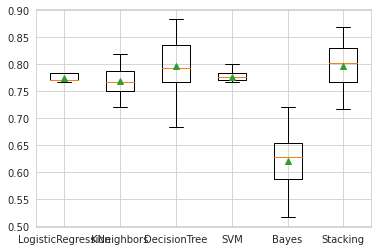

In [24]:
train_evaluate_models(X_train, y_train)

## Apply muller loop classifiers on second micro-factor: Confirmation

**Apply Train Test Split**

In [25]:
X, y = df['Statement'].values, df['Confirmation'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

**Apply frequency, inverse document frequency:**

In [26]:
X_train, X_test = apply_count_vector(X_train, X_test)
X_train, X_test = apply_tfidf(X_train, X_test)

>LogisticRegression accuracy:0.628 (std: 0.022)
>KNeighbors accuracy:0.630 (std: 0.057)
>DecisionTree accuracy:0.619 (std: 0.042)
>SVM accuracy:0.621 (std: 0.016)
>Bayes accuracy:0.568 (std: 0.061)
>Stacking accuracy:0.632 (std: 0.040)


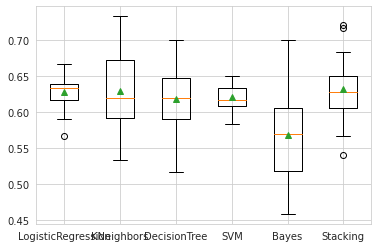

In [27]:
train_evaluate_models(X_train, y_train)

##Apply Neural Network on Sentiment

**Apply Count Vector and TFIDF on Text**

In [28]:
def process_data(df, micro_factor='Confirmation'):
  # Apply One hot encoding on negative and positive
  one_hot = pd.get_dummies(df[micro_factor])
  df = pd.concat([df,one_hot],axis=1)
  
  # Apply Train Test Split
  X, y = df['Statement'].values, df[['Positive', 'Negative']].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
  
  # Apply Count Vector and TFIDF on Text
  X_train, X_test = apply_count_vector(X_train, X_test)
  X_train, X_test = apply_tfidf(X_train, X_test)
  return X_train, X_test, y_train, y_test

**Add different layers in CNN model**

In [29]:
def construct_model(X_train, X_test, y_train, y_test):
  model = Sequential()

  model.add(Dense(units=12673,activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(units=4000,activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(units=500,activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(units=2, activation='softmax'))

  opt=tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

  early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

  model.fit(x=X_train, y=y_train, batch_size=20, epochs=50, validation_data=(X_test, y_test), verbose=1, callbacks=early_stop)

**Apply the Model**

In [30]:
X_train, X_test, y_train, y_test = process_data(df, micro_factor='Sentiment')
construct_model(X_train, X_test, y_train, y_test)

Epoch 1/50
31/31 [==============================] - 22s 645ms/step - loss: 0.6163 - accuracy: 0.7313 - val_loss: 0.4919 - val_accuracy: 0.7808
Epoch 2/50
31/31 [==============================] - 19s 625ms/step - loss: 0.3121 - accuracy: 0.8172 - val_loss: 0.7872 - val_accuracy: 0.7154
Epoch 3/50
31/31 [==============================] - 19s 623ms/step - loss: 0.0094 - accuracy: 0.9989 - val_loss: 1.1687 - val_accuracy: 0.7385
Epoch 00003: early stopping


## Apply Neural Network on Confirmation

In [31]:
X_train, X_test, y_train, y_test = process_data(df, micro_factor='Confirmation')
construct_model(X_train, X_test, y_train, y_test)

Epoch 1/50
31/31 [==============================] - 21s 626ms/step - loss: 0.6882 - accuracy: 0.5902 - val_loss: 0.6601 - val_accuracy: 0.6462
Epoch 2/50
31/31 [==============================] - 19s 612ms/step - loss: 0.3001 - accuracy: 0.9223 - val_loss: 1.7168 - val_accuracy: 0.5769
Epoch 3/50
31/31 [==============================] - 19s 612ms/step - loss: 0.0828 - accuracy: 0.9822 - val_loss: 2.2092 - val_accuracy: 0.5885
Epoch 00003: early stopping


**Conclusion**

1. Both sentiment and confirmation are predictable by the article content.
2. Stacking ensembling model performs better than single model.
3. CNN performs better than other models.